In [2]:
import json
import csv
import os
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from matplotlib import pyplot as plt
from collections import defaultdict

AUROC score is 0.7563
AUROC score is 0.7557
AUROC score is 0.7559
AUROC score is 0.7530
AUROC score is 0.7485
Averaged AUC is 0.7538972707647407
S@Recall60 = 0.7748
avg_acc@Recall60 = 0.7573, avg_f1@Recall60 = 0.3384

S@Recall65 = 0.7297
avg_acc@Recall65 = 0.7379, avg_f1@Recall65 = 0.3315

S@Recall70 = 0.6707
avg_acc@Recall70 = 0.7183, avg_f1@Recall70 = 0.3248

S@Recall75 = 0.6186
avg_acc@Recall75 = 0.6983, avg_f1@Recall75 = 0.3189

R@Spec60 = 0.7655
avg_acc@Spec60 = 0.6153, avg_f1@Spec75 = 0.2917

R@Spec65 = 0.7221
avg_acc@Spec65 = 0.6368, avg_f1@Spec75 = 0.2978

R@Spec70 = 0.6739
avg_acc@Spec70 = 0.6563, avg_f1@Spec75 = 0.3030

R@Spec75 = 0.6321
avg_acc@Spec75 = 0.6762, avg_f1@Spec75 = 0.3099

R@Spec77.3 = 0.6032
avg_acc@Spec77.3 = 0.6920, avg_f1@Spec75 = 0.3154



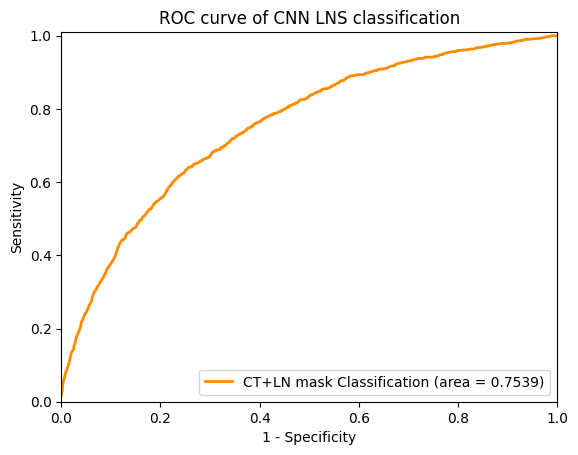

In [15]:


folds = [0, 1, 2, 3, 4]
fprs, tprs, thres_all = [], [], []
cv_per_LNS_results = []
preds, labels = [], []
auc_scores = []

exp_root = "2022-12-22-10:56:34_Chuanzhong_CT_mobilenet_v3_large_3d_z_dspl3_bsz32_lr5e-5_wd5e-5_24_96_96_Adam_AddLNMask_z_downspl3_aug_p05_05_epoch200"
exp_subfolders = "test_results_best_epoch/mobilenetv3_3d_chuanzhong_bce_loss"
exp_pred_file = "predictions.txt"

for fold in folds:
    results_path = os.path.join(root, exp_root, "fold_{}".format(fold), exp_subfolders, exp_pred_file)
    # load prediction txt file
    with open(results_path, 'r') as f:
        results = f.read().splitlines()

    # save per station prediction results
    per_LNS_results = defaultdict(list)
    for item in results:
        fname, label, logit = item.split(',')
        LNS_name = fname.split('_')[1]
        per_LNS_results[LNS_name].append([int(label), float(logit)])
    cv_per_LNS_results.append(per_LNS_results)
    
    # gather all (stations) predictions and labels
    all_results = np.concatenate([val for key, val in per_LNS_results.items()], axis=0)
    
    # calculate metrics
    fpr, tpr, thres = roc_curve(all_results[:, 0], all_results[:, 1])
    fprs.append(fpr)
    tprs.append(tpr)
    thres_all.append(thres)
    preds.append(all_results[:, 1])
    labels.append(all_results[:, 0])
    
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    print("AUROC score is {:.4f}".format(roc_auc))

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(len(folds)):
    mean_tpr += np.interp(fpr_grid, fprs[i], tprs[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= len(folds)

fpr_macro = fpr_grid
tpr_macro = mean_tpr
roc_auc_marco = auc(fpr_macro, tpr_macro)
print("Averaged AUC is {}".format(roc_auc_marco))

acc, f1 = [], []
for r_cutoff in [60, 65, 70, 75]:
    s_at_recall_idx = np.argmin(np.abs(tpr_macro - r_cutoff / 100.0))
    s_at_recall = 1 - fpr_macro[s_at_recall_idx]
    print("S@Recall{} = {:.4f}".format(r_cutoff, s_at_recall))
    
    for i in range(len(folds)):
        cur_tprs = tprs[i]
        cur_preds = preds[i]
        cur_labels = labels[i]
        cur_index = np.argmin(np.abs(cur_tprs - r_cutoff / 100.0))
        cur_thres = thres_all[i][cur_index]
        
        binary_pred = (cur_preds >= cur_thres) * 1.0
        hit = (binary_pred == cur_labels) * 1.0
        accuracy = np.sum(hit) / hit.shape[0]
        acc.append(accuracy)
        roc_f1_score = f1_score(cur_labels, binary_pred, average='binary')
        f1.append(roc_f1_score)
    print("avg_acc@Recall{} = {:.4f}, avg_f1@Recall{} = {:.4f}\n".format(r_cutoff, np.mean(acc), r_cutoff, np.mean(f1)))

acc, f1 = [], []
for s_cutoff in [60, 65, 70, 75, 77.3]:
    r_at_spec_idx = np.argmin(np.abs((1 - fpr_macro) - s_cutoff / 100.0))
    r_at_spec = tpr_macro[r_at_spec_idx]
    print("R@Spec{} = {:.4f}".format(s_cutoff, r_at_spec))
    
    for i in range(len(folds)):
        cur_fprs = fprs[i]
        cur_preds = preds[i]
        cur_labels = labels[i]
        cur_index = np.argmin(np.abs((1 - cur_fprs) - s_cutoff / 100.0))
        cur_thres = thres_all[i][cur_index]
        
        binary_pred = (cur_preds >= cur_thres) * 1.0
        hit = (binary_pred == cur_labels) * 1.0
        accuracy = np.sum(hit) / hit.shape[0]
        acc.append(accuracy)
        roc_f1_score = f1_score(cur_labels, binary_pred, average='binary')
        f1.append(roc_f1_score)
    print("avg_acc@Spec{} = {:.4f}, avg_f1@Spec{} = {:.4f}\n".format(s_cutoff, np.mean(acc), r_cutoff, np.mean(f1)))

plt.figure()
lw = 2

# draw
plt.plot(
    fpr_macro,
    tpr_macro,
    color=line_colors[0],
    lw=lw,
    label="%s (area = %0.4f)" % ('CT+LN mask Classification', roc_auc_marco),
)

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.01])
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title(f"ROC curve of CNN LNS classification")
plt.legend(loc="lower right")
plt.show()

LNS: t07
Positive ratio 54.0 / 337
AUROC score is 0.6440
S@Recall65 = 0.5654
R@Spec0.9571 = 0.0741
acc@Recall65 = 0.5786, f1@Recall65 = 0.3302

S@Recall70 = 0.5442
R@Spec0.9571 = 0.0741
acc@Recall70 = 0.5742, f1@Recall70 = 0.3370

S@Recall75 = 0.5336
R@Spec0.9571 = 0.0741
acc@Recall75 = 0.5717, f1@Recall75 = 0.3427

S@Recall80 = 0.4876
R@Spec0.9571 = 0.0741
acc@Recall80 = 0.5631, f1@Recall80 = 0.3459



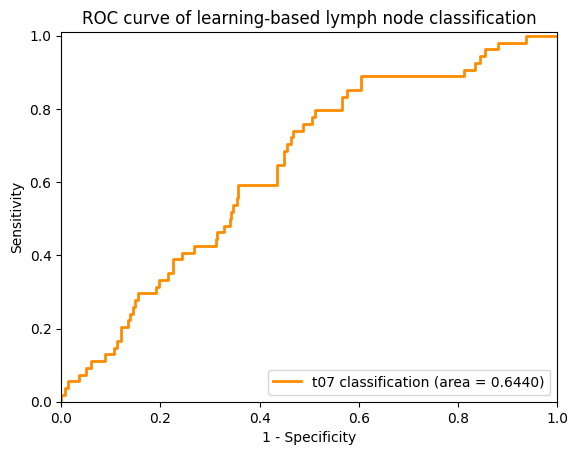

LNS: t02
Positive ratio 83.0 / 383
AUROC score is 0.6826
S@Recall65 = 0.6133
R@Spec0.9571 = 0.2410
acc@Recall65 = 0.6214, f1@Recall65 = 0.4269

S@Recall70 = 0.5767
R@Spec0.9571 = 0.2410
acc@Recall70 = 0.6123, f1@Recall70 = 0.4299

S@Recall75 = 0.4933
R@Spec0.9571 = 0.2410
acc@Recall75 = 0.5918, f1@Recall75 = 0.4275

S@Recall80 = 0.4533
R@Spec0.9571 = 0.2410
acc@Recall80 = 0.5757, f1@Recall80 = 0.4261



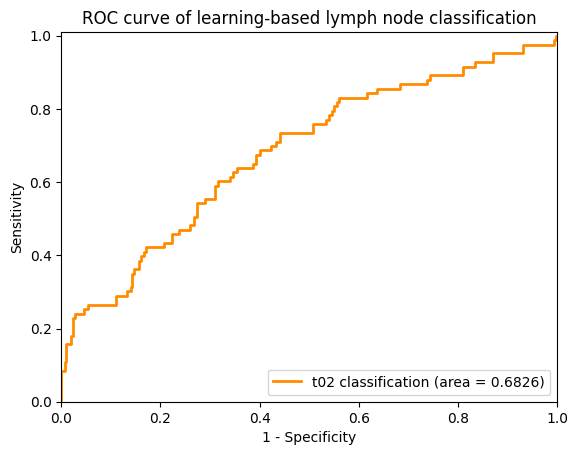

LNS: t04
Positive ratio 13.0 / 311
AUROC score is 0.5385
S@Recall65 = 0.4732
R@Spec0.9571 = 0.0000
acc@Recall65 = 0.4791, f1@Recall65 = 0.0899

S@Recall70 = 0.3993
R@Spec0.9571 = 0.0000
acc@Recall70 = 0.4453, f1@Recall70 = 0.0897

S@Recall75 = 0.3255
R@Spec0.9571 = 0.0000
acc@Recall75 = 0.4116, f1@Recall75 = 0.0896

S@Recall80 = 0.3255
R@Spec0.9571 = 0.0000
acc@Recall80 = 0.3947, f1@Recall80 = 0.0895



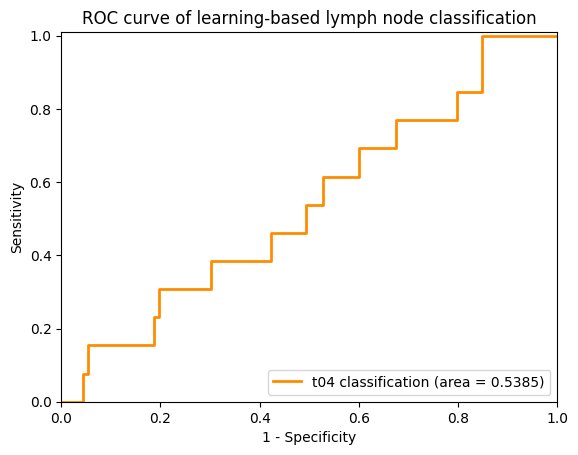

LNS: t08
Positive ratio 58.0 / 338
AUROC score is 0.6010
S@Recall65 = 0.5500
R@Spec0.9571 = 0.0517
acc@Recall65 = 0.5651, f1@Recall65 = 0.3348

S@Recall70 = 0.4321
R@Spec0.9571 = 0.0517
acc@Recall70 = 0.5222, f1@Recall70 = 0.3263

S@Recall75 = 0.4250
R@Spec0.9571 = 0.0517
acc@Recall75 = 0.5079, f1@Recall75 = 0.3270

S@Recall80 = 0.3464
R@Spec0.9571 = 0.0517
acc@Recall80 = 0.4867, f1@Recall80 = 0.3254



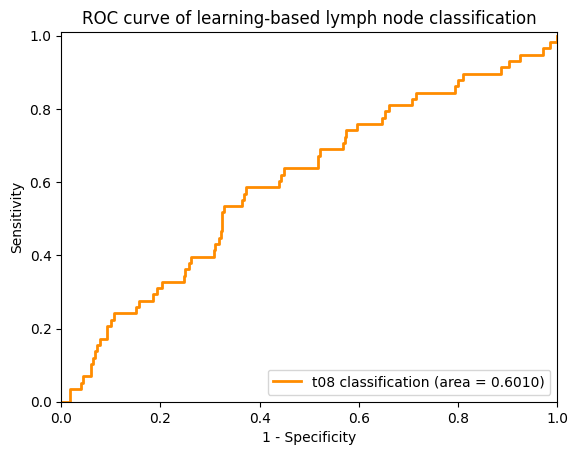

In [13]:
for LNS_name, LNS_res in cv_per_LNS_results[0].items():
    print("LNS: {}".format(LNS_name))
    cur_res = np.asarray(LNS_res)
    print("Positive ratio {} / {}".format(cur_res[:, 0].sum(), cur_res.shape[0]))

    plt.figure()
    lw = 2
        
    fpr, tpr, thres = roc_curve(cur_res[:, 0], cur_res[:, 1])
    roc_auc = auc(fpr, tpr)
    print("AUROC score is {:.4f}".format(roc_auc))

    # # selecting operating point (Youden Index)
    # youden = (1 - fpr) + tpr - 1
    # thres_index = np.argmax(youden)
    # if LNS_name == 't07':
    #     customized_thres = -1.3862943611198906
    #     thres_index =  np.argmin(np.abs(customized_thres - thres))
    # elif LNS_name == 't01':
    #     customized_thres = -5.109977737428519
    #     thres_index =  np.argmin(np.abs(customized_thres - thres))
        
    # operating_thres = thres[thres_index]
    # print("cutoff is {}".format(operating_thres))

    # binary_pred = cur_res[:, 1] >= operating_thres
    # hit = binary_pred == cur_res[:, 0]
    # accuracy = np.sum(hit) / hit.shape[0]
    # print(f"Sen. at Youden is {tpr[thres_index]:.4f}, Spe. at Youden is {1 - fpr[thres_index]:.4f}\n")
    # print(f"Accuracy at Youden is {accuracy:.4f}")
    # roc_f1_score = f1_score(cur_res[:, 0], binary_pred, average='binary')
    # print(f"F1 score is {roc_f1_score:.4f}")

    # # PPV and NPV
    # PPV = np.sum(binary_pred[cur_res[:, 0] == 1]) / np.sum(binary_pred == 1)
    # NPV = np.sum((1 - binary_pred)[cur_res[:, 0] == 0]) / np.sum(binary_pred == 0)
    # print(f"\nPPV is {PPV:.4f} and NPV is {NPV:.4f}")
    acc, f1 = [], []
    for r_cutoff in [65, 70, 75, 80]:
        s_at_recall_idx = np.argmin(np.abs(tpr - r_cutoff / 100.0))
        s_at_recall = 1 - fpr[s_at_recall_idx]
        print("S@Recall{} = {:.4f}".format(r_cutoff, s_at_recall))
        
        # rcut = 0.6
        # s_at_recall_idx = np.argmin(np.abs(tpr - rcut))
        # s_at_recall = 1 - fpr[s_at_recall_idx]
        # print("S@Recall{} = {:.4f}".format(rcut, s_at_recall))
        scut = 0.9571
        s_at_recall_idx = np.argmin(np.abs(1 - fpr - scut))
        s_at_recall = tpr[s_at_recall_idx]
        print("R@Spec{} = {:.4f}".format(scut, s_at_recall))
        
        cur_tprs = tpr
        cur_preds = cur_res[:, 1]
        cur_labels = cur_res[:, 0]
        cur_index = np.argmin(np.abs(cur_tprs - r_cutoff / 100.0))
        cur_thres = thres[cur_index]
        
        binary_pred = (cur_preds >= cur_thres) * 1.0
        hit = (binary_pred == cur_labels) * 1.0
        accuracy = np.sum(hit) / hit.shape[0]
        acc.append(accuracy)
        roc_f1_score = f1_score(cur_labels, binary_pred, average='binary')
        f1.append(roc_f1_score)
        print("acc@Recall{} = {:.4f}, f1@Recall{} = {:.4f}\n".format(r_cutoff, np.mean(acc), r_cutoff, np.mean(f1)))

    # draw
    plt.plot(
        fpr,
        tpr,
        color=line_colors[0],
        lw=lw,
        label="%s classification (area = %0.4f)" % (LNS_name, roc_auc),
    )
    # plot max youden index
    # x = fpr[thres_index]
    # y = tpr[thres_index]
    # plt.plot(x, y, marker='p', markersize=7, color='red', linestyle = 'None', label="Learning-based Youden Index cutoff")
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1.01])
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.title(f"ROC curve of learning-based lymph node classification")
    plt.legend(loc="lower right")
    plt.show()

#### SLNS results

AUROC score is 0.7553
S@Recall65 = 0.7300
acc@Recall65 = 0.7190, f1@Recall65 = 0.3892

S@Recall70 = 0.6613
acc@Recall70 = 0.6928, f1@Recall70 = 0.3779

S@Recall75 = 0.5879
acc@Recall75 = 0.6653, f1@Recall75 = 0.3674

S@Recall80 = 0.5224
acc@Recall80 = 0.6391, f1@Recall80 = 0.3590



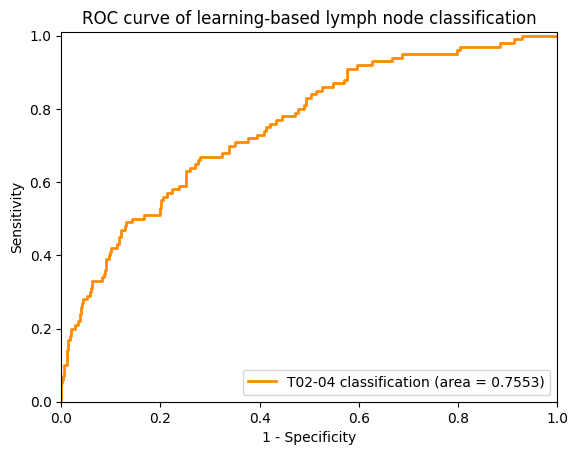

In [5]:
T02_04 = np.concatenate([per_LNS_results['t02'], per_LNS_results['t03.p'], per_LNS_results['t04']])
plt.figure()
lw = 2
cur_res = T02_04
fpr, tpr, thres = roc_curve(cur_res[:, 0], cur_res[:, 1])
roc_auc = auc(fpr, tpr)
print("AUROC score is {:.4f}".format(roc_auc))

# selecting operating point (Youden Index)
# youden = (1 - fpr) + tpr - 1
# thres_index = np.argmax(youden)
# operating_thres = thres[thres_index]

# binary_pred = cur_res[:, 1] >= operating_thres
# hit = binary_pred == cur_res[:, 0]
# accuracy = np.sum(hit) / hit.shape[0]
# print(f"Sen. at Youden is {tpr[thres_index]:.4f}, Spe. at Youden is {1 - fpr[thres_index]:.4f}\n")
# print(f"Accuracy at Youden is {accuracy:.4f}")
# roc_f1_score = f1_score(cur_res[:, 0], binary_pred, average='binary')
# print(f"F1 score is {roc_f1_score:.4f}")

# # PPV and NPV
# PPV = np.sum(binary_pred[cur_res[:, 0] == 1]) / np.sum(binary_pred == 1)
# NPV = np.sum((1 - binary_pred)[cur_res[:, 0] == 0]) / np.sum(binary_pred == 0)
# print(f"\nPPV is {PPV:.4f} and NPV is {NPV:.4f}")
acc, f1 = [], []
for r_cutoff in [65, 70, 75, 80]:
    s_at_recall_idx = np.argmin(np.abs(tpr - r_cutoff / 100.0))
    s_at_recall = 1 - fpr[s_at_recall_idx]
    print("S@Recall{} = {:.4f}".format(r_cutoff, s_at_recall))
    
    cur_tprs = tpr
    cur_preds = cur_res[:, 1]
    cur_labels = cur_res[:, 0]
    cur_index = np.argmin(np.abs(cur_tprs - r_cutoff / 100.0))
    cur_thres = thres[cur_index]
    
    binary_pred = (cur_preds >= cur_thres) * 1.0
    hit = (binary_pred == cur_labels) * 1.0
    accuracy = np.sum(hit) / hit.shape[0]
    acc.append(accuracy)
    roc_f1_score = f1_score(cur_labels, binary_pred, average='binary')
    f1.append(roc_f1_score)
    print("acc@Recall{} = {:.4f}, f1@Recall{} = {:.4f}\n".format(r_cutoff, np.mean(acc), r_cutoff, np.mean(f1)))

# draw
plt.plot(
    fpr,
    tpr,
    color=line_colors[0],
    lw=lw,
    label="T02-04 classification (area = %0.4f)" % (roc_auc),
)
# plot max youden index
# x = fpr[thres_index]
# y = tpr[thres_index]
# plt.plot(x, y, marker='p', markersize=7, color='red', linestyle = 'None', label="Learning-based Youden Index cutoff")
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.01])
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title(f"ROC curve of learning-based lymph node classification")
plt.legend(loc="lower right")
plt.show()